# Domain Generating Algorithms - Model / Feature Selection

Now that we've explored the data and developed a pipeline for generating features, let's identifying which type of classification model is up to the task.

There are a couple of considerations:
* Scoring, how well does the model generalise to data it was not trained particularly given the imbalanced nature of the data
* Complexity, is the model one that we can explain to people who may not have an understanding of model development but may be held accountable for the decisions made by the model.
* Time, how long does it take for the model to be fit

Depending on the siutation we can make different trade-offs on the above. I am assuming that priorities are in the order that they listed.

In [1]:
import os
from time import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

Change our working directory so our project src import will work.

In [2]:
os.chdir("../")

In [3]:
! ls data

external
interim
processed
raw


Yes we are let's import the function we need to prepare our data.

## Reading in and Preprocessing Data

In [4]:
from src.pipeline import prepare_model_inputs

In [5]:
df = pd.read_csv("data/raw/dga_domains.csv")

Using our pipeline for preparing model inputs lets get a test and train split.

Depending on the model we choose we have to apply a label encoding to the `class` column. For the purposes of comparing model families lets replace the textual `class` descriptions with 0 and 1.

In [30]:
class_replacements = {"dga": 1, "legit": 0}

In [6]:
feature_names, X_train, X_test, y_train, y_test = prepare_model_inputs(
    df, ["domain"], "class", class_replacements, 0.3, random_state_split=42
)

## Model Evaluation

There are a number of different types classification models we could use, let's fit our data to some naive unoptimised model to see which model families hold some promise.

We'll be comparing a number of metrics:
* `accuracy_score`: What percentage of predictions were correct? 
* `precision_score`: TruePositive / (TruePositive + FalsePositive)
* `recall_score`: TruePositive / (TruePositive + FalseNegative)
* `f1_score`: (2 * Precision * Recall) / (Precision + Recall)
* `fit_time_in_seconds`: How long did the model take to fit? If we were continously rebuilding the model as we received inputs having some idea of how long the process takes would be an important metric to consider for capacity planning purposes.

In addition we'll be capturing (where possible) a measure of the models "complexity". However we will not compare this across the model families as the is no simple equvilance of "complexity" across model families. Rather it is discriminate within the same family. 

In [7]:
def naive_model_evaluation(
    X_train, y_train,
    X_test, y_test,
    tuning_param_values,
    get_model,
    get_model_complexity = None,
):
    
    models = dict()
    
    col_names = [
        'type', 'hyper_param_val', 'complexity', "accuracy_score", 
        "precision_score", "recall_score", "f1_score", "fit_time_in_seconds"
    ]

    metrics = np.zeros((len(Cs), len(col_names)))
    metrics[:,1] = tuning_param_values

    for index, value in enumerate(tuning_param_values):
        model = get_model(value)

        fit_start = time()
        model.fit(X_train, y_train)
        fit_time_in_seconds = float(time() - fit_start)
        
        models[value] = model

        test_predictions = model.predict(X_test)
        
        if get_model_complexity is not None:
            metrics[index, 2] = get_model_complexity(model)
        else:
            metrics[index, 2] = np.nan
                
        metrics[index, 3] = accuracy_score(y_test, test_predictions)
        metrics[index, 4] = precision_score(y_test, test_predictions)
        metrics[index, 5] = recall_score(y_test, test_predictions)
        metrics[index, 6] = f1_score(y_test, test_predictions)
        metrics[index, 7] = fit_time_in_seconds


    metrics_df = pd.DataFrame(metrics, columns=col_names)
    metrics_df["type"] = type(model).__name__
    
    display(metrics_df)
    
    return models, metrics_df   
    

In [8]:
NUMER_OF_ITERATIONS = 5

In [9]:
Cs = np.linspace(0.0001, 1.0, NUMER_OF_ITERATIONS)

In [10]:
from sklearn.linear_model import LogisticRegression

def get_logistic_reg(c):
    return LogisticRegression(
        class_weight="balanced", 
        random_state = 42,
        penalty = 'l1',
        C = c,        
        solver = "liblinear",
    )

def get_logistic_reg_complexity(model):
    return np.count_nonzero(model.coef_)

logistic_regressors, logistic_regressors_df = naive_model_evaluation(
    X_train, y_train,
    X_test, y_test,
    Cs, get_logistic_reg, get_logistic_reg_complexity,
)

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,LogisticRegression,0.000100,2.0,0.856162,0.872768,0.804494,0.837241,0.266001
1,LogisticRegression,0.250075,41.0,0.884248,0.878967,0.867785,0.873340,0.620486
2,LogisticRegression,0.500050,42.0,0.884277,0.878974,0.867848,0.873376,0.626493
3,LogisticRegression,0.750025,42.0,0.884306,0.878982,0.867911,0.873412,0.642989
4,LogisticRegression,1.000000,42.0,0.884306,0.878982,0.867911,0.873412,0.645517


In [11]:
from sklearn.linear_model import SGDClassifier

def get_sgd(alpha):
    return SGDClassifier(
        alpha=alpha,
        max_iter=1000, 
        tol=1e-3
    )

def get_sgd_complexity(model):
    return np.count_nonzero(model.coef_)

sgds, sgds_df = naive_model_evaluation(
    X_train, y_train,
    X_test, y_test,
    Cs, get_sgd, get_sgd_complexity,
)

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,SGDClassifier,0.000100,43.0,0.879329,0.895373,0.835190,0.864235,0.618498
1,SGDClassifier,0.250075,43.0,0.878282,0.935849,0.789430,0.856427,0.159010
2,SGDClassifier,0.500050,43.0,0.871878,0.945443,0.765570,0.846052,0.159999
3,SGDClassifier,0.750025,43.0,0.867891,0.950909,0.751519,0.839538,0.138018
4,SGDClassifier,1.000000,43.0,0.862361,0.953469,0.736646,0.831149,0.159005


In [12]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = np.linspace(5, 2500, NUMER_OF_ITERATIONS, dtype=int)

def get_random_forrest(n):
    return RandomForestClassifier(
        n_estimators=n,
        class_weight="balanced",
        random_state=42,
        n_jobs = -1,
    )

def get_random_forrest_complexity(model):
    return np.count_nonzero(model.feature_importances_)

rfs, rfs_df = naive_model_evaluation(
    X_train, y_train,
    X_test, y_test,
    n_estimators, get_random_forrest, get_random_forrest_complexity,
)

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,RandomForestClassifier,5.0,43.0,0.944700,0.939540,0.940253,0.939896,0.263502
1,RandomForestClassifier,628.0,43.0,0.949881,0.944999,0.946076,0.945537,18.906498
2,RandomForestClassifier,1252.0,43.0,0.949968,0.945122,0.946139,0.945631,38.225503
3,RandomForestClassifier,1876.0,43.0,0.949939,0.944950,0.946266,0.945607,64.946489
4,RandomForestClassifier,2500.0,43.0,0.949968,0.945066,0.946203,0.945634,101.753003


In [13]:
from sklearn.neighbors import KNeighborsClassifier

# smaller values of k are more complex models
n_neighbours = np.flip(np.linspace(3, 600, 5, dtype=int))

def get_knn(n):
    return KNeighborsClassifier(
            n_neighbors = n,
            n_jobs = -1
        )

knns, knn_df = naive_model_evaluation(
    X_train, y_train,
    X_test, y_test,
    n_neighbours, get_knn, None,
)

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,KNeighborsClassifier,600.0,NaN,0.827522,0.943735,0.664557,0.779915,22.774496
1,KNeighborsClassifier,450.0,NaN,0.829472,0.944628,0.668354,0.782831,22.670012
2,KNeighborsClassifier,301.0,NaN,0.852960,0.942961,0.724051,0.819132,22.808508
3,KNeighborsClassifier,152.0,NaN,0.876186,0.936819,0.783608,0.853391,25.008512
4,KNeighborsClassifier,3.0,NaN,0.881105,0.884224,0.853165,0.868417,29.642512


In [14]:
from sklearn.neural_network import MLPClassifier

def get_mlp(alpha):
    return MLPClassifier(
        alpha=1, 
        max_iter=1000
    )

def get_mlp_complexity(model):
    return np.count_nonzero(model.coefs_)

mlps, mlp_df = naive_model_evaluation(
    X_train, y_train,
    X_test, y_test,
    Cs, get_mlp, None,
)

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,MLPClassifier,0.000100,NaN,0.935968,0.944619,0.914367,0.929247,32.018000
1,MLPClassifier,0.250075,NaN,0.936056,0.946556,0.912468,0.929200,33.840493
2,MLPClassifier,0.500050,NaN,0.934688,0.944867,0.911139,0.927697,41.369992
3,MLPClassifier,0.750025,NaN,0.935706,0.944528,0.913861,0.928941,34.659997
4,MLPClassifier,1.000000,NaN,0.934775,0.947935,0.908038,0.927558,23.745996


In [15]:
all_models_df = pd.concat([
    logistic_regressors_df,
    sgds_df,
    rfs_df,
    knn_df,
    mlp_df,
])

In [16]:
all_models_df["type"].unique()

array(['LogisticRegression', 'SGDClassifier', 'RandomForestClassifier',
       'KNeighborsClassifier', 'MLPClassifier'], dtype=object)

In [17]:
def display_top_quartile_scores(all_models_df, column, smaller_is_better = False, groupby = "type", unstack = True):
    column_scores = all_models_df[column].describe()    
    
    report_df = all_models_df[all_models_df[column] >= column_scores["75%"]].sort_values(column, ascending = False)
    
    if smaller_is_better:
        report_df = all_models_df[all_models_df[column] <= column_scores["25%"]].sort_values(column, ascending = True)
    
    display(report_df.reset_index(drop=True))
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    if unstack:
        plot_score_df = all_models_df[[groupby,column]].groupby(groupby).apply(lambda x: x.unstack()).drop(groupby, axis = 1).T
        plot_score_df.columns = plot_score_df.columns.get_level_values(0)
    else:
        plot_score_df = all_models_df[[groupby,column]].set_index(groupby)
    
    plot_score_df = plot_score_df.reset_index(drop = True)
    return plot_score_df.plot(ax = ax)

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,RandomForestClassifier,1252.000000,43.0,0.949968,0.945122,0.946139,0.945631,38.225503
1,RandomForestClassifier,2500.000000,43.0,0.949968,0.945066,0.946203,0.945634,101.753003
2,RandomForestClassifier,1876.000000,43.0,0.949939,0.944950,0.946266,0.945607,64.946489
3,RandomForestClassifier,628.000000,43.0,0.949881,0.944999,0.946076,0.945537,18.906498
4,RandomForestClassifier,5.000000,43.0,0.944700,0.939540,0.940253,0.939896,0.263502
5,MLPClassifier,0.250075,NaN,0.936056,0.946556,0.912468,0.929200,33.840493
6,MLPClassifier,0.000100,NaN,0.935968,0.944619,0.914367,0.929247,32.018000


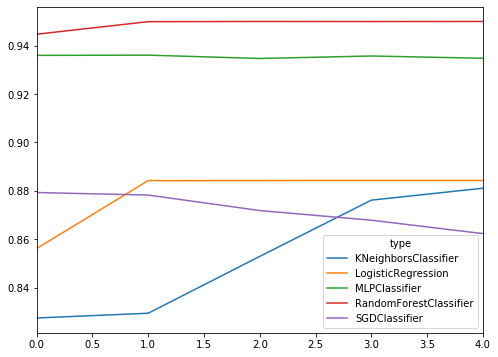

In [18]:
display_top_quartile_scores(all_models_df, "accuracy_score")

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,SGDClassifier,1.000000,43.0,0.862361,0.953469,0.736646,0.831149,0.159005
1,SGDClassifier,0.750025,43.0,0.867891,0.950909,0.751519,0.839538,0.138018
2,MLPClassifier,1.000000,NaN,0.934775,0.947935,0.908038,0.927558,23.745996
3,MLPClassifier,0.250075,NaN,0.936056,0.946556,0.912468,0.929200,33.840493
4,SGDClassifier,0.500050,43.0,0.871878,0.945443,0.765570,0.846052,0.159999
5,RandomForestClassifier,1252.000000,43.0,0.949968,0.945122,0.946139,0.945631,38.225503
6,RandomForestClassifier,2500.000000,43.0,0.949968,0.945066,0.946203,0.945634,101.753003


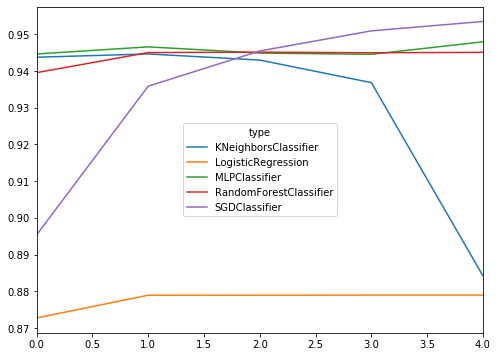

In [19]:
display_top_quartile_scores(all_models_df, "precision_score")

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,RandomForestClassifier,1876.000000,43.0,0.949939,0.944950,0.946266,0.945607,64.946489
1,RandomForestClassifier,2500.000000,43.0,0.949968,0.945066,0.946203,0.945634,101.753003
2,RandomForestClassifier,1252.000000,43.0,0.949968,0.945122,0.946139,0.945631,38.225503
3,RandomForestClassifier,628.000000,43.0,0.949881,0.944999,0.946076,0.945537,18.906498
4,RandomForestClassifier,5.000000,43.0,0.944700,0.939540,0.940253,0.939896,0.263502
5,MLPClassifier,0.000100,NaN,0.935968,0.944619,0.914367,0.929247,32.018000
6,MLPClassifier,0.750025,NaN,0.935706,0.944528,0.913861,0.928941,34.659997


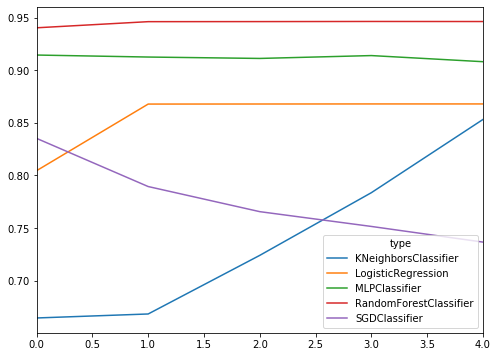

In [20]:
display_top_quartile_scores(all_models_df, "recall_score")

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,RandomForestClassifier,2500.000000,43.0,0.949968,0.945066,0.946203,0.945634,101.753003
1,RandomForestClassifier,1252.000000,43.0,0.949968,0.945122,0.946139,0.945631,38.225503
2,RandomForestClassifier,1876.000000,43.0,0.949939,0.944950,0.946266,0.945607,64.946489
3,RandomForestClassifier,628.000000,43.0,0.949881,0.944999,0.946076,0.945537,18.906498
4,RandomForestClassifier,5.000000,43.0,0.944700,0.939540,0.940253,0.939896,0.263502
5,MLPClassifier,0.000100,NaN,0.935968,0.944619,0.914367,0.929247,32.018000
6,MLPClassifier,0.250075,NaN,0.936056,0.946556,0.912468,0.929200,33.840493


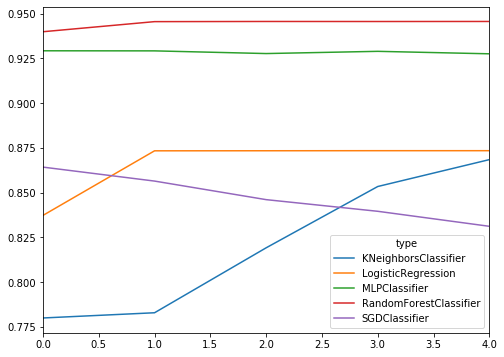

In [21]:
display_top_quartile_scores(all_models_df, "f1_score")

,type,hyper_param_val,complexity,accuracy_score,precision_score,recall_score,f1_score,fit_time_in_seconds
0,SGDClassifier,0.750025,43.0,0.867891,0.950909,0.751519,0.839538,0.138018
1,SGDClassifier,1.000000,43.0,0.862361,0.953469,0.736646,0.831149,0.159005
2,SGDClassifier,0.250075,43.0,0.878282,0.935849,0.789430,0.856427,0.159010
3,SGDClassifier,0.500050,43.0,0.871878,0.945443,0.765570,0.846052,0.159999
4,RandomForestClassifier,5.000000,43.0,0.944700,0.939540,0.940253,0.939896,0.263502
5,LogisticRegression,0.000100,2.0,0.856162,0.872768,0.804494,0.837241,0.266001
6,SGDClassifier,0.000100,43.0,0.879329,0.895373,0.835190,0.864235,0.618498


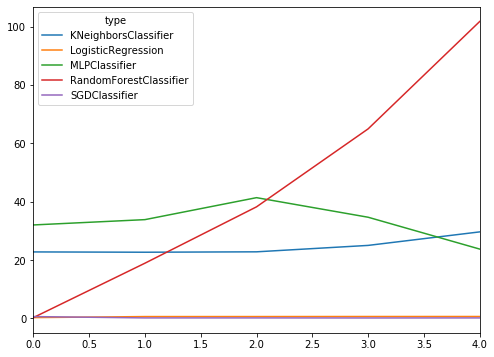

In [22]:
display_top_quartile_scores(all_models_df, "fit_time_in_seconds", True)

Consider all of the above, it seems our RandomForrest with 628 estimators is a viable candidate.

In [23]:
candidate_model = rfs[628]

One attribute of forrest based models is they are able to report the relative importance of the features used in building the forrest.

In [24]:
def get_importances(estimator, X_columns):
    return pd.Series(estimator.feature_importances_, index = X_columns).sort_values(ascending = False)

In [26]:
candiate_importances = get_importances(candidate_model, feature_names)
print(candiate_importances)
print("len(candiate_importances)", len(candiate_importances))

len__domain_normed_len                                                0.289891
vowel_ratio__domain_normed_vowel_ratio                                0.203054
consonants_variety_ratio__domain_normed_consonants_variety_ratio      0.191464
vowel_distance_std_ratio__domain_normed_vowel_distance_std_ratio      0.171732
vowel_distance_mode_ratio__domain_normed_vowel_distance_mode_ratio    0.050814
digit_ratio__domain_normed_digit_ratio                                0.022287
character_pairs__domain_normed_character_pair_in                      0.003176
character_pairs__domain_normed_character_pair_or                      0.003030
character_pairs__domain_normed_character_pair_on                      0.002968
character_pairs__domain_normed_character_pair_re                      0.002967
character_pairs__domain_normed_character_pair_er                      0.002919
character_pairs__domain_normed_character_pair_an                      0.002769
character_pairs__domain_normed_character_pair_ar    

Let's evaluate our candidate model and another model that we'll build with the same number of estimators but using a reduced number of features.

In [27]:
def display_confusion_matrix(y_actual, y_predictions, class_names):
    
    cm = confusion_matrix(y_actual, y_predictions)
    
    df_cm = pd.DataFrame(
        cm, index = class_names, columns = class_names, 
    )
    
    figsize = (10,7)
    fontsize=14    
    
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [28]:
def evaluate_model(model, X_train, y_train, X_test, y_test, class_names):
    
    train_predictions = model.predict(X_train)
    print("Training Report")
    print(classification_report(y_train, train_predictions))
    
    test_predictions = model.predict(X_test)
    print("Test Report")
    print(classification_report(y_test, test_predictions))
    
    display_confusion_matrix(y_test, test_predictions, class_names)

Training Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     43302
           1       0.98      0.98      0.98     36865

    accuracy                           0.98     80167
   macro avg       0.98      0.98      0.98     80167
weighted avg       0.98      0.98      0.98     80167

Test Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     18558
           1       0.94      0.95      0.95     15800

    accuracy                           0.95     34358
   macro avg       0.95      0.95      0.95     34358
weighted avg       0.95      0.95      0.95     34358



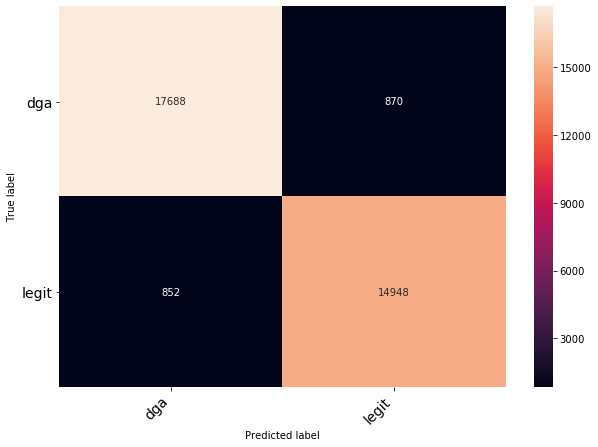

In [31]:
evaluate_model(candidate_model, X_train, y_train, X_test, y_test, class_replacements.keys())